# Estimating hotspot(s) emission and rotational axis from visibilties. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os

import jax
from jax import random
from jax import numpy as jnp
import jax.scipy.ndimage as jnd
import scipy.ndimage as nd

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import xarray as xr
import flax
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils, observation_utils
from network_utils import shard

import ehtim as eh
import ehtim.const_def as ehc
from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

# from jax.config import config
# config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3a5p1w1g because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



In [2]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission, emission_test, velocity_field, hparams, runname, 
                  log_period=100, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    obs_times = np.linspace(0, 1.0, measurements.shape[0])

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    t = obs_times
    train_vis = measurements

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = measurements_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()
    t_test = obs_times

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D_FROM_FOURIER(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, 0.0, 1.0)['params']

    def flattened_traversal(fn):
        def mask(data):
            flat = flax.traverse_util.flatten_dict(data)
            return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
        return mask

    tx = optax.chain(
        optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                     mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
        optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                     mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
    )

    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images = intensity_to_nchw(emission.isel(t=0))
        writer.add_images('emission/true', images, global_step=0)
        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
                loss_test, _, _, _, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), 0.0, 1.0, shard(test_vis[batch_inds,...]), state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(float(loss_test))), global_step=i)

                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    0.0, 1.0, shard(test_vis[0,...]), state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)

            # Training
            batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), 0.0, 1.0, 
                shard(train_vis[batch_inds, ...]), state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(float(np.mean(loss_train))), global_step=i)
            
    return state, emission_vis, axis_estimation

In [4]:
# Generate hotspot emission
nt, nx, ny, nz = 64, 64, 64, 64
nt_test = 64
nspots = 1
r_isco = 3.0 

phi = 0                # azimuth angle (ccw from x-axis)
theta = np.pi / 3.0    # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco)

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 0.03
emission *= normalization_factor
emission_test *= normalization_factor

In [241]:
extent = [(float(initial_frame[dim].min()), float(initial_frame[dim].max())) for dim in initial_frame.dims]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [240]:
# Generate hotspot emission
nt, nx, ny, nz = 64, 64, 64, 64
nt_test = 64
nspots = 1
r_isco = 3.0 

phi = np.pi            # azimuth angle (ccw from x-axis)
theta = np.pi / 3.0    # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco)

nspots = 8
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
initial_frame = emission_utils.generate_orbit_3d(initial_frame, nt, 1, rot_axis).isel(
    t=np.random.choice(range(0, nt, 5), size=nspots)).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)
emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

normalization_factor = 0.03305721036378928
emission *= normalization_factor
emission_test *= normalization_factor

In [242]:
# Generate image plane fluxes
fov = 160.0

sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
sensor = sensor.fillna(0.0)

image_plane = emission_utils.integrate_rays(emission, sensor).data.reshape(nt, sensor.num_alpha, sensor.num_beta)
image_plane_test = emission_utils.integrate_rays(emission_test, sensor).data.reshape(nt_test, sensor.num_alpha, sensor.num_beta)

# Generate Fourier measurements
# measurements = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.ifftshift(image_plane)))
# measurements_test = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.ifftshift(image_plane_test)))
measurements = image_plane
measurements_test = image_plane_test

In [249]:
%matplotlib widget
plt.imshow(image_plane[10], extent=[-80,80,-80,80])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [250]:
fov = 160
obs_params = {
    'array': eh.array.load_txt('../eht_arrays/ngEHT.txt'),
    'nt': 128,      # number of time samples 
    'tstart': 4.0,  # start of observations (UTC hr)
    'tstop': 15.5,  # end of observation (UTC hr)
    'tint': 60.0    # integration time
}
obs_empty = observation_utils.empty_eht_obs(**obs_params)
obs_args = {
    'psize': fov / sensor.num_alpha * ehc.RADPERUAS,
    'ra': obs_empty.ra, 
    'dec': obs_empty.dec,
    'rf': obs_empty.rf, 
    'mjd': obs_empty.mjd
}
image = eh.image.Image(image_plane[10], **obs_args)

In [251]:
obs = image.observe_same_nonoise(obs_empty)

Producing clean visibilities from image with nfft FT . . . 


In [259]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
image.display(axis=ax[0])
obs.plotall('uvdist', 'amp', axis=ax[1], ebar=False)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

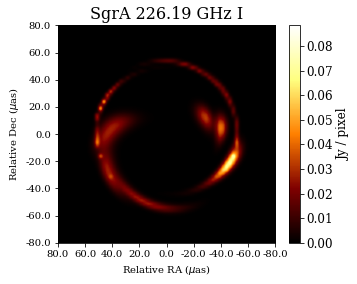

In [253]:
image.display()

In [ ]:
eh.image.Image(image_plane[30]

In [201]:
# Visualize radiance measurements 
%matplotlib widget
image_plane_visualization = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])
anim = image_plane_visualization.utils_visualization.animate()

# outpath = 'gifs/ngEHT.measurements.nspots{:d}.theta_{:2.0f}.phi_{:2.0f}.gif'.format(
#     nspots, np.rad2deg(theta), np.rad2deg(phi))
# anim.save(outpath, writer='imagemagick', fps=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [82]:
# Training parameters
hparams = {
    'num_iters': 20000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-1,
    'posenc_deg': 3,
    'batchsize': 1,
    'r_min': r_min
}
runname = 'fourier/test_gt'.format(
    nspots, sensor.num_alpha, sensor.num_beta, sensor.geo.size)

state, emission_vis, rot_axis_est = train_network(
    sensor, emission, emission_test, velocity_field, hparams, 
    runname=runname, log_period=100, x_res_vis=64, y_res_vis=64, z_res_vis=64
)
emission_estimate = emission_utils.generate_orbit_3d(
    xr.DataArray(emission_vis[0], coords=initial_frame.coords), nt, velocity_field, rot_axis_est)

[autoreload of network_utils failed: Traceback (most recent call last):
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packag

iteration:   0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
extent = [(float(initial_frame[dim].min()), float(initial_frame[dim].max())) for dim in initial_frame.dims]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission_estimate.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [38]:
# Save measurement prediction
plt.rcdefaults()

image_prediction = emission_utils.integrate_rays(emission_estimate, sensor)
image_prediction = xr.DataArray(image_prediction.data.reshape(nt, sensor.num_alpha, sensor.num_beta), dims=['t', 'alpha', 'beta'])

%matplotlib widget
outpath = 'gifs/ngEHT.prediction.nspots{:d}.theta_{:2.0f}.phi_{:2.0f}.gif'.format(
    nspots, np.rad2deg(theta), np.rad2deg(phi))
image_prediction.utils_visualization.animate(output=outpath)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [39]:
%matplotlib widget
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.scatter(0,0,0, color='black', s=50)
ax.quiver(0,0,0,*rot_axis, length=0.05, linewidths=3,  label='true')
ax.quiver(0,0,0,*rot_axis_est, length=0.05, linewidths=3, label='estimated', color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# DEBUG

In [158]:
log_period=100
x_res_vis=64
y_res_vis=64
z_res_vis=64

hparams = {
    'num_iters': 50000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'lr_axis': 1e-1,
    'posenc_deg': 3,
    'batchsize': 1024,
    'r_min': r_min
}

In [ ]:
obs_times = np.linspace(0, 1.0, measurements.shape[0])

# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
t, x, y, z, d = train_coords.values()
t = obs_times
train_vis = measurements

test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
test_vis = measurements_test
t_test, x_test, y_test, z_test, d_test = test_coords.values()
t_test = obs_times

# Emission visualization inputs
t_res_vis = 1
emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                          np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                          np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                          indexing='ij')

d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization

# Model setup and initialization
rng = jax.random.PRNGKey(1)
predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D_FROM_FOURIER(posenc_deg=hparams['posenc_deg'])
params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, 0.0, 1.0)['params']

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

tx = optax.chain(
    optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                 mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
    optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                 mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
)

state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, None, None, None, 0, 0, 0), static_broadcasted_argnums=(0))
rand_key = jax.random.split(rng, jax.local_device_count())
state = flax.jax_utils.replicate(state)

In [156]:
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
sensor = sensor.fillna(0.0)

In [171]:
obs_times = np.linspace(0, 1.0, measurements.shape[0])

# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=obs_times)
t, x, y, z, d = train_coords.values()
train_radiance = measurements.ravel() 

test_coords = network_utils.get_input_coords(sensor, t_array=obs_times)
test_radiance = measurements_test.ravel() 
t_test, x_test, y_test, z_test, d_test = test_coords.values()

# Emission visualization inputs
t_res_vis = 1
emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1], emission.z[0], emission.z[-1]]
t_vis, x_vis, y_vis, z_vis  = np.meshgrid(0.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                          np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                          np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                          indexing='ij')

d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization 

# Model setup and initialization
rng = jax.random.PRNGKey(1)
predictor = network_utils.PREDICT_EMISSION_AND_ROTAXIS_3D(posenc_deg=hparams['posenc_deg'])
params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field)['params']

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

tx = optax.chain(
    optax.masked(optax.adam(learning_rate=hparams['lr_axis']),
                 mask=flattened_traversal(lambda path, _: path[-1] == 'axis')),
    optax.masked(optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters'])),
                 mask=flattened_traversal(lambda path, _: path[-1] != 'axis')),
)

state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
rand_key = jax.random.split(rng, jax.local_device_count())
state = flax.jax_utils.replicate(state)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [194]:
t.shape

(262144, 100)

In [193]:
t[batch_inds, ...]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [191]:
i = 1
batch_inds = 50

t_vis, x_vis, y_vis, z_vis  = np.meshgrid(1.0, np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                          np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                          np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                          indexing='ij')

# batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
loss_test, _, _,rend,_, _ = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]),
    shard(test_radiance[batch_inds,...]), state, rand_key
)

_, _, emission_vis, _, axis_estimation, _ = eval_pstep(
    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
    shard(test_vis[0,...]), state, rand_key
)
axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
#emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))

In [185]:
extent = [(float(initial_frame[dim].min()), float(initial_frame[dim].max())) for dim in initial_frame.dims]
ipv.figure()
ipv.view(0, -60, distance=2.5)
ipv.volshow(emission_vis[0], extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
ipv.show()

In [173]:
plt.figure()
plt.imshow(emission_vis[0,0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
i = 1
batch_inds = 0

# batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
loss_test, _, _, _, _, _, fourier = eval_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), 0.0, 1.0, shard(test_vis[batch_inds,...]), state, rand_key
)


In [124]:
plt.figure()
sensor.alpha.data.reshape(64,64,100)[35,35]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888

In [112]:
%matplotlib widget
plt.imshow(np.sum(d[0], axis=-1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [109]:
%matplotlib widget
plt.imshow(fourier[0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [94]:
%matplotlib widget
plt.imshow(test_vis[batch_inds])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# Log prediction and estimate
_, _, emission_vis, _, axis_estimation, _ = eval_pstep(
    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
    0.0, 1.0, shard(test_vis[0,...]), state, rand_key
)
axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
emission_vis = np.reshape(emission_vis, [t_res_vis, x_res_vis, y_res_vis, z_res_vis])
emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 >= hparams['r_min']**2, emission_vis, jnp.zeros_like(emission_vis))

# Training
# batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
loss_train, state, _, _, _, rand_key = train_pstep(
    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), 0.0, 1.0, 
    shard(train_vis[batch_inds, ...]), state, rand_key
)

In [38]:
velocity = velocity_field
fov = 160.0
tstart = 0.0
tstop = 1.0
k = 5

emission, axis = predictor.apply({'params': state.params}, x[k], y[k], z[k], t[k], velocity, tstart, tstop)

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "axis" in "/": (1, 3), (3,). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)